In [1]:
# General
import numpy as np
import torch
import torch.nn.functional as F
from importlib import reload
from types import SimpleNamespace
import shap

# Custom
import utils
reload(utils)

import data
reload(data)

import train
reload(train)

import modules
reload(modules)
from modules import GCN, GCN_GNNExplainer, GCN_GraphSVX
from modules import GraphSAGE
from torch_geometric.data import DataLoader
import torch.optim as optim

import explanations
reload(explanations)
from explanations import LIME_explanation, SHAP_explanation

import GraphSVX_explainers
reload(GraphSVX_explainers)
from GraphSVX_explainers import GraphSVX

%matplotlib inline
import torch_geometric
from torch_geometric.data import Data



In [3]:
seed=42
torch.manual_seed(seed)


hyperparameters = {'hidden_channels': 15,
                   'num_heads': 3,
                    'dropout': 0.2,
                    'lr': 0.001,
                    'epochs': 1000,
                    'beta': 0.9999,
                    'seed':seed}


model, traindata, testdata, feature_names, target_names, running_train_loss, running_test_loss, accuracy = train.train_graphSAGE_foroptuna(hyperparameters, verbose = True)
#model, traindata, testdata, feature_names, target_names, running_train_loss, running_test_loss, accuracy = train.train_GAT_GraphSVX_foroptuna(hyperparameters, verbose = True)

n_sar_accs_train = traindata.y[traindata.y == 1].shape[0]
n_sar_accs_test = testdata.y[testdata.y == 1].shape[0]
print(f"Number of SARs in training set: {n_sar_accs_train} out of {traindata.y.shape[0]}")
print(f"Number of SARs in test set: {n_sar_accs_test} out of {testdata.y.shape[0]}")

epoch: 1, train_loss: 0.3437, test_loss: 0.31856629252433777, accuracy: 0.1533, balanced_accuracy: 0.5025, precision: 0.0301, recall: 0.8739, f0.9999: 0.0583
epoch: 10, train_loss: 0.3222, test_loss: 0.3118846118450165, accuracy: 0.3887, balanced_accuracy: 0.5114, precision: 0.0310, recall: 0.6418, f0.9999: 0.0592
epoch: 20, train_loss: 0.3065, test_loss: 0.3072710335254669, accuracy: 0.5229, balanced_accuracy: 0.5411, precision: 0.0349, recall: 0.5605, f0.9999: 0.0658
epoch: 30, train_loss: 0.2934, test_loss: 0.29836732149124146, accuracy: 0.7013, balanced_accuracy: 0.5869, precision: 0.0470, recall: 0.4652, f0.9999: 0.0854
epoch: 40, train_loss: 0.2801, test_loss: 0.28698813915252686, accuracy: 0.8207, balanced_accuracy: 0.6092, precision: 0.0668, recall: 0.3843, f0.9999: 0.1138
epoch: 50, train_loss: 0.2675, test_loss: 0.2720961272716522, accuracy: 0.8903, balanced_accuracy: 0.6012, precision: 0.0905, recall: 0.2936, f0.9999: 0.1383
epoch: 60, train_loss: 0.2558, test_loss: 0.257454

## EVAL 


In [4]:
model.set_return_type('log_probas')
from sklearn.metrics import confusion_matrix
import numpy as np
torch.manual_seed(seed)
np.random.seed(seed)

model.eval()

print('Confusion matrix')
with torch.no_grad():
    out = model.forward(testdata.x, testdata.edge_index)
    out = torch.exp(out)
    y_pred = out.cpu().numpy().argmax(axis=1)
    
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)


#find the indices of the predicted class 1
sar_indices = np.where(y_pred == 1)[0]
print('Sar indices',sar_indices, len(sar_indices))
print('Sar predicteds true labels', y_true[sar_indices], len(sar_indices))
true_positives=sar_indices[y_true[sar_indices]==1]
print('True positives', true_positives)

Confusion matrix
[[92480  4296]
 [ 1071  1919]]
Sar indices [    2    12    16 ... 99609 99720 99764] 6215
Sar predicteds true labels [0 1 0 ... 0 0 0] 6215
True positives [   12    80    95 ... 98590 98680 98684]


In [11]:


testdata=testdata.to('cpu')
model=model.to('cpu')

node_to_explain = sar_indices[2].item()
print(f'Explaining node {node_to_explain} which was prediced SAR.')
print(f'The node was predicted {out[node_to_explain].argmax().item()} with probability {out[node_to_explain,out[node_to_explain].argmax().item()].item():.4f}.')
print(f'The true label is {testdata.y[node_to_explain]}.\n')

subset_expl, edge_index_expl, _, _ = torch_geometric.utils.k_hop_subgraph(node_to_explain, 3, testdata.edge_index, relabel_nodes=False)
org_to_new_mapping, new_to_org_mapping, edges_new = utils.node_index_mapping(subset_expl, edge_index_expl)

n_nodes=subset_expl.shape[0]
print('number of nodes', n_nodes)
num_samples=5*n_nodes


data=SimpleNamespace()
data.x=testdata.x
data.edge_index=edge_index_expl
data.y=testdata.y
data.num_nodes=testdata.x.shape[0]
data.num_classes=2
data.name='test'

explainer=GraphSVX(data,model,True)
explanations = explainer.explain(node_indexes=[node_to_explain], num_samples=num_samples, hops = 3, vizu = False, seed=seed, args_coal='SmarterSeparate')


Explaining node 16 which was prediced SAR.
The node was predicted 1 with probability 0.8460.
The true label is 0.

number of nodes 105
self neighbours tensor([  217,  1020,  2910,  3515,  4350,  5671,  5768,  7016,  8000,  9811,
        10220, 10402, 11369, 11769, 11932, 12029, 12091, 12182, 12358, 12572,
        12702, 14083, 16348, 16455, 17454, 20077, 21084, 22721, 23791, 24011,
        24967, 25806, 25979, 26719, 27134, 29178, 29378, 29808, 32393, 40685,
        40752, 40776, 41256, 43150, 43545, 43803, 46173, 46841, 47090, 47534,
        48254, 48605, 49367, 49412, 52978, 54708, 54713, 54996, 55632, 58733,
        61761, 62355, 63363, 63399, 64504, 65193, 65829, 66244, 66246, 66266,
        66581, 66785, 67449, 67703, 67800, 69083, 69643, 70879, 71658, 71811,
        73165, 75798, 79320, 80487, 82651, 82796, 85044, 85220, 86621, 86896,
        88115, 88433, 88782, 88830, 91008, 91238, 91355, 91535, 92052, 93645,
        95362, 97075, 97692, 98140])
one_hop_neighbours tensor([   16

525it [00:16, 32.59it/s]


r2:  0.9993036782849368
weighted r2:  0.9999995491379494
Explanations include 16 node features and 104 neighbours for this node        for 2 classes
Neighbors are tensor([  217,  1020,  2910,  3515,  4350,  5671,  5768,  7016,  8000,  9811,
        10220, 10402, 11369, 11769, 11932, 12029, 12091, 12182, 12358, 12572,
        12702, 14083, 16348, 16455, 17454, 20077, 21084, 22721, 23791, 24011,
        24967, 25806, 25979, 26719, 27134, 29178, 29378, 29808, 32393, 40685,
        40752, 40776, 41256, 43150, 43545, 43803, 46173, 46841, 47090, 47534,
        48254, 48605, 49367, 49412, 52978, 54708, 54713, 54996, 55632, 58733,
        61761, 62355, 63363, 63399, 64504, 65193, 65829, 66244, 66246, 66266,
        66581, 66785, 67449, 67703, 67800, 69083, 69643, 70879, 71658, 71811,
        73165, 75798, 79320, 80487, 82651, 82796, 85044, 85220, 86621, 86896,
        88115, 88433, 88782, 88830, 91008, 91238, 91355, 91535, 92052, 93645,
        95362, 97075, 97692, 98140])
Model prediction is 

In [12]:
data = Data(x=data.x[subset_expl],edge_index=edges_new,y=data.y[subset_expl])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

In [13]:
feature_names = [ 'sum', 'mean', 'median', 'std', 'max', 'min', 'in_sum', 'out_sum', 'in_mean', 'out_mean', 'in_median', 'out_median', 'in_std', 'out_std', 'in_max', 'out_max', 'in_min', 'out_min', 'count_in', 'count_out', 'n_unique_in', 'n_unique_out', 'count_days_in_bank', 'count_phone_changes', 'sum_spending', 'mean_spending', 'median_spending', 'std_spending', 'max_spending', 'min_spending', 'count_spending']

len(feature_names)

31

In [14]:
org_to_new_mapping

{16: 0,
 217: 1,
 1020: 2,
 2910: 3,
 3515: 4,
 4350: 5,
 5671: 6,
 5768: 7,
 7016: 8,
 8000: 9,
 9811: 10,
 10220: 11,
 10402: 12,
 11369: 13,
 11769: 14,
 11932: 15,
 12029: 16,
 12091: 17,
 12182: 18,
 12358: 19,
 12572: 20,
 12702: 21,
 14083: 22,
 16348: 23,
 16455: 24,
 17454: 25,
 20077: 26,
 21084: 27,
 22721: 28,
 23791: 29,
 24011: 30,
 24967: 31,
 25806: 32,
 25979: 33,
 26719: 34,
 27134: 35,
 29178: 36,
 29378: 37,
 29808: 38,
 32393: 39,
 40685: 40,
 40752: 41,
 40776: 42,
 41256: 43,
 43150: 44,
 43545: 45,
 43803: 46,
 46173: 47,
 46841: 48,
 47090: 49,
 47534: 50,
 48254: 51,
 48605: 52,
 49367: 53,
 49412: 54,
 52978: 55,
 54708: 56,
 54713: 57,
 54996: 58,
 55632: 59,
 58733: 60,
 61761: 61,
 62355: 62,
 63363: 63,
 63399: 64,
 64504: 65,
 65193: 66,
 65829: 67,
 66244: 68,
 66246: 69,
 66266: 70,
 66581: 71,
 66785: 72,
 67449: 73,
 67703: 74,
 67800: 75,
 69083: 76,
 69643: 77,
 70879: 78,
 71658: 79,
 71811: 80,
 73165: 81,
 75798: 82,
 79320: 83,
 80487: 84,
 826

In [15]:
new_to_org_mapping

{0: 16,
 1: 217,
 2: 1020,
 3: 2910,
 4: 3515,
 5: 4350,
 6: 5671,
 7: 5768,
 8: 7016,
 9: 8000,
 10: 9811,
 11: 10220,
 12: 10402,
 13: 11369,
 14: 11769,
 15: 11932,
 16: 12029,
 17: 12091,
 18: 12182,
 19: 12358,
 20: 12572,
 21: 12702,
 22: 14083,
 23: 16348,
 24: 16455,
 25: 17454,
 26: 20077,
 27: 21084,
 28: 22721,
 29: 23791,
 30: 24011,
 31: 24967,
 32: 25806,
 33: 25979,
 34: 26719,
 35: 27134,
 36: 29178,
 37: 29378,
 38: 29808,
 39: 32393,
 40: 40685,
 41: 40752,
 42: 40776,
 43: 41256,
 44: 43150,
 45: 43545,
 46: 43803,
 47: 46173,
 48: 46841,
 49: 47090,
 50: 47534,
 51: 48254,
 52: 48605,
 53: 49367,
 54: 49412,
 55: 52978,
 56: 54708,
 57: 54713,
 58: 54996,
 59: 55632,
 60: 58733,
 61: 61761,
 62: 62355,
 63: 63363,
 64: 63399,
 65: 64504,
 66: 65193,
 67: 65829,
 68: 66244,
 69: 66246,
 70: 66266,
 71: 66581,
 72: 66785,
 73: 67449,
 74: 67703,
 75: 67800,
 76: 69083,
 77: 69643,
 78: 70879,
 79: 71658,
 80: 71811,
 81: 73165,
 82: 75798,
 83: 79320,
 84: 80487,
 85:

Explaining node 16 which was prediced SAR.
The node was predicted SAR (label 1) with probability 0.8460.
The true label is 0.

Number of SVs 120
Number of features 16
Number of nodes 104
120
105
ding
Length of size_map: 105
Number of nodes in the graph: 105


16
hej 16 16


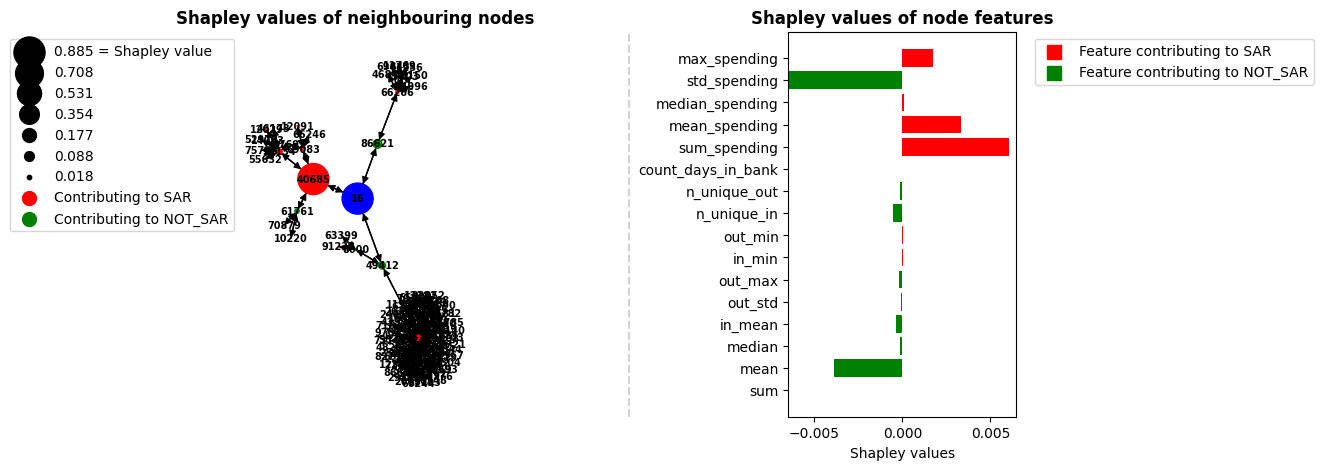

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

G=to_networkx(data)

# --- Printing information about node prediction ---
print(f'Explaining node {node_to_explain} which was prediced SAR.')
print(f'The node was predicted SAR (label 1) with probability {out[node_to_explain,out[node_to_explain].argmax().item()].item():.4f}.')
print(f'The true label is {testdata.y[node_to_explain]}.\n')


# # --- Extract Shapley values ---
F = explainer.F
D = explanations[0].shape[0] - F
SV = explanations[0]
SV_features = SV[:F]
SV_nodes = SV[F:]

print(f'Number of SVs {len(SV)}')
print(f'Number of features {len(SV_features)}')
print(f'Number of nodes {len(SV_nodes)}')

# Node coloring
color_map = ['blue']
size_map = [500]
labels = {0: node_to_explain}
SV_max = np.abs(SV_nodes).max()
SV_min = np.abs(SV_nodes).min()


for i in range(len(SV_nodes)): 
    SV_node = SV_nodes[i]
    size_map.append(500 * np.abs(SV_node) / SV_max)
    labels[i+1] = new_to_org_mapping[i+1]
    if SV_node < 0:
        color_map.append('green')
    else: 
        color_map.append('red')

print(len(SV))
print(len(size_map))
#print(testdata_expl.x.shape[0])

# Create figure
fig = plt.figure(figsize=(10, 5))

# --- Subplot for nodes ---
plt.subplot(1,3,1)

pos = nx.spring_layout(G)
print('ding')
#pos = nx.kamada_kawai_layout(G)
print("Length of size_map:", len(size_map))
print("Number of nodes in the graph:", len(G.nodes))


nx.draw(G, pos=pos, with_labels=True, labels=labels, node_color=color_map, node_size=size_map, font_size=7, font_weight='bold')


# Add legend
plt.scatter([], [], c='black', s=500, label=f'{SV_max:.3f} = Shapley value')
plt.scatter([], [], c='black', s=400, label=f'{4/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=300, label=f'{3/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=200, label=f'{2/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=100, label=f'{1/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=50, label=f'{50/500*SV_max:.3f}')
plt.scatter([], [], c='black', s=10, label=f'{10/500*SV_max:.3f}')
plt.scatter([], [], c='red', s=100, label='Contributing to SAR')
plt.scatter([], [], c='green', s=100, label='Contributing to NOT_SAR')
plt.legend(bbox_to_anchor=(0, 1),loc='upper right')

plt.title('Shapley values of neighbouring nodes',fontweight='bold')

# --- Add vertical line to separate the plots ---
plt.subplot(1, 3, 2)
plt.axvline(x=5, color='lightgray', linestyle='--')
plt.axis('off')  # Turn off axis

# --- Shapley Values for features ---
plt.subplot(1, 3, 3)

# Extract features that are used in the explanation, and get their original feature names
feat_idx, discarded_feat_idx = explainer.feature_selection(node_to_explain, "Expectation") # Using 0 here since 0 is node_to_explain in the subgraph
print(len(feat_idx))
feature_names_in_explanation = [feature_names[i] for i in feat_idx]

colors = ['green' if e < 0 else 'red' for e in SV_features]
plt.barh(range(len(SV_features)), SV_features, color=colors)
xlim = np.abs(SV_features).max()
plt.xlim(-xlim, xlim)
print('hej',len(SV_features), len(feature_names_in_explanation))
plt.yticks(range(len(SV_features)), feature_names_in_explanation)
plt.xlabel('Shapley values')
plt.scatter([], [], c='red', s=100, marker = 's', label='Feature contributing to SAR')
plt.scatter([], [], c='green', s=100, marker = 's', label='Feature contributing to NOT_SAR')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Shapley values of node features',fontweight='bold')

# --- Plot figures ---
plt.show()


In [ ]:
def find_true_label(node_index, dataset):
    return dataset.y[node_index].item()

print(SV_nodes)

print("Nodes contributing positively to the explanation:")
for i in range(len(SV_nodes)): 
    SV_node = SV_nodes[i]
    if SV_node > 0.05 :
        print(f"Node {new_to_org_mapping[i+1]} with shapley value {SV_node:.4f} contributes positively to the explanation.")
        print(f"The true label of the node is {find_true_label(new_to_org_mapping[i+1], testdata)}.")
        
for i in range(len(SV_nodes)): 
    SV_node = SV_nodes[i]
    if SV_node < -0.05 :
        print(f"Node {new_to_org_mapping[i+1]} with shapley value {SV_node:.4f} contributes negatively to the explanation.")
        print(f"The true label of the node is {find_true_label(new_to_org_mapping[i+1], testdata)}.")


# Calculate the sum of the Shapley values for the nodes
sum_SV_nodes = SV_nodes.sum()
print(f"The sum of the Shapley values for the nodes is {sum_SV_nodes:.4f}.")
print(f"The sum of the Shapley values for the features is {SV_features.sum():.4f}.")
print(f"The sum of the Shapley values for the nodes and features is {sum_SV_nodes + SV_features.sum():.4f}.")
print(f"The sum of the Shapley values for the features and nodes should be equal to the difference between the prediction for the node and the base value.")
print(f"Prediction for node {node_to_explain} is {out[node_to_explain,out[node_to_explain].argmax().item()].item():.4f}.")


[ 0.0043502   0.01139029  0.00442284  0.00406416  0.00414521  0.00410835
 -0.02517697  0.0041559   0.05767363  0.00441539  0.00421986  0.00085763
  0.00831227  0.00713628  0.01157169  0.00413654  0.00816235  0.17370359
  0.0087683   0.00425854  0.00420629  0.00388603  0.00376317  0.00240747
  0.00454686  0.00404885  0.00422124  0.00435407  0.00412074  0.00398159
  0.00419083  0.00363588  0.00515982  0.00426358  0.0041918   0.01374182
  0.34828857  0.00436017  0.00409927  0.0042308   0.00424156  0.00532216
  0.00435284  0.0044136   0.04188331  0.00398003  0.0043289   0.01325673
  0.00395179  0.00399861 -0.01350019 -0.05225823  0.00641343  0.00392122
  0.00424498  0.01686858  0.00435337  0.00428124  0.00410761  0.00430339
  0.00410244  0.00411984  0.00429633  0.00429049  0.00391441 -0.02629108
  0.00436139  0.00475603]
Nodes contributing positively to the explanation:
Node 11222 with shapley value 0.0577 contributes positively to the explanation.
The true label of the node is 1.
Node 189

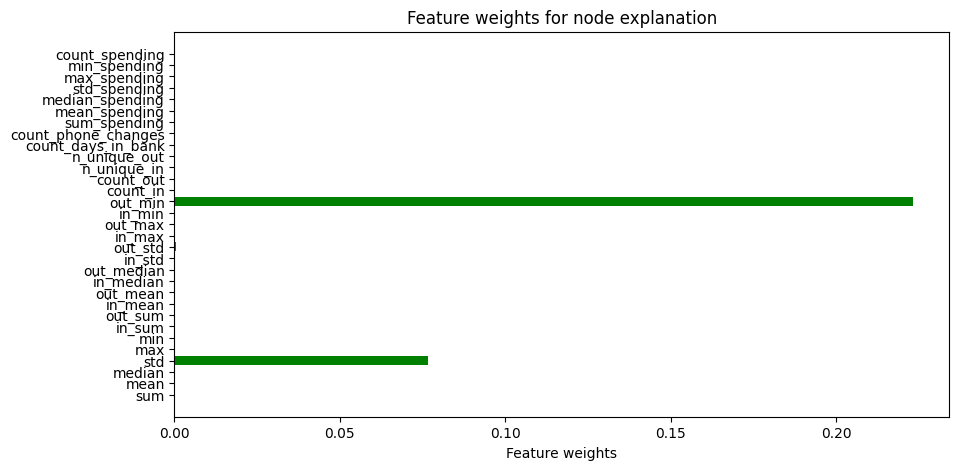

In [9]:

from GraphSVX_explainers import GraphLIME
import matplotlib.pyplot as plt


explainer = GraphLIME(data, model, hop=3, rho=0.1, cached=True)

# node_to_explain.to('cpu')

# explain node features by calling the method `explain_node()`
coefs = explainer.explain_node(node_to_explain, data.x, data.edge_index)

coefs

#plot the explanation
plt.figure(figsize=(10, 5))
plt.barh(range(len(coefs)), coefs, color=['red' if c < 0 else 'green' for c in coefs])
plt.yticks(range(len(coefs)), feature_names)
plt.xlabel('Feature weights')
plt.title('Feature weights for node explanation')
plt.show()
